# Challenge: Edit MNIST challenge images to be correctly predicted

Goal: Edit the images placed in `data/MNIST/challenge` so that the provided model predicts the correct label while keeping more than 60% of the original pixels unchanged.

Description: You are given a pre-trained `SmallCNN` model and a small set of challenge images. Your task is to minimally modify these images so the model classifies them correctly. This exercise encourages you to: 
- Explore the sample dataset in `data/MNIST/sample` to understand variation and typical inputs.
- Use explainable AI (XAI) techniques (saliency maps, Grad-CAM, Integrated Gradients, occlusion, etc.) to discover what parts of the image the model relies on.
- Propose minimal edits (pixel changes, small masks, subtle color shifts) that change model prediction while preserving at least 60% of the original pixels.

Deliverables: For each edited image, save the modified image to `data/MNIST/challenge/edited/` alongside a short report (less than 2 pages) describing the XAI insights you used and the percentage of pixels preserved. For ease of use, you have the images already in that folder and you can directly work on them. You are allowed to use any external program you want to modify the image (i.e., paint, photoshop, figma, ...).

The practice can be done by more than 1 person. Final grade would depend on the number of images correctly edited (n_images_correct) with their corresponding report and number of persons working together (n_persons) following the next formula:
$$grade = 2,5 \times n\_images\_correct - 2,5 * (n\_persons - 1)$$


In [182]:
# Imports and device
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import numpy as np
import re
from IPython.display import display

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [183]:
# SmallCNN definition (must match the trained model architecture)
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(12*7*7, 12)
        self.fc2 = nn.Linear(12, num_classes)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))  # 14x14
        x = self.pool(x)                      # 7x7
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.nn.functional.relu(self.fc1(x)))
        return self.fc2(x)

# convenience transform
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

In [184]:
models_dir = Path('../models')
model_name = models_dir / 'small_cnn.pth'
model = torch.load(model_name, weights_only=False)
model.to(device) 
model.eval()

SmallCNN(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=588, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=10, bias=True)
)

0_label5.png: Pred: 1, Label: 5
1_label3.png: Pred: 1, Label: 3
2_label3.png: Pred: 1, Label: 3
3_label7.png: Pred: 3, Label: 7
4_label2.png: Pred: 6, Label: 2


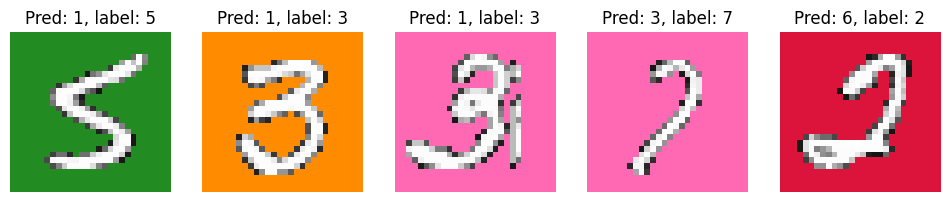

In [185]:
# Load the images in data/MNIST/challenge/ and plot them. Label of the image is the last character of the filename.
challenge_dir = Path('../data/MNIST/challenge')
image_files = list(challenge_dir.glob('*.png'))
fig, axes = plt.subplots(1, len(image_files), figsize=(12,4))
for ax, img_file in zip(axes, image_files):
    img = to_tensor(Image.open(img_file)).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(dim=1).item()
    ax.imshow(to_pil(img.squeeze().cpu()))
    ax.set_title(f'Pred: {pred}, label: {img_file.stem[-1]}')
    ax.axis('off')
    print(f'{img_file.name}: Pred: {pred}, Label: {img_file.stem[-1]}')
plt.show()

---
### Any code you want to add, put it below this markdown cell

## Explicabilidad y Edición Basada en Gradientes

Implementación de **Integrated Gradients (IG)** y **Saliency Maps**, que permiten identificar las zonas de la imagen que más influyen en la predicción del modelo:

- **Integrated Gradients (IG)**: interpola entre una imagen base (negra) y la imagen real, acumulando los gradientes a lo largo del camino. Permite estimar qué píxeles aportan de forma positiva o negativa a la clase objetivo.  
- **Saliency Map**: calcula el gradiente directo de la salida del modelo respecto a los píxeles. Cuanto mayor es el valor absoluto, mayor impacto tiene ese píxel en la decisión.

A partir de estos mapas de importancia, he aplicado diferentes técnicas de modificación:
1. **OFF**: apagar (poner a 0) los píxeles más relevantes para eliminar señales erróneas.
2. **ON**: encender (poner a 1) los píxeles más importantes, reforzando rasgos clave de la clase correcta.


In [200]:
# =========================
# Métodos XAI
# =========================
@torch.no_grad()
def get_pred(model: nn.Module, x: torch.Tensor) -> int:
    """
    Devuelve la clase predicha por el modelo.
    model(x) -> logits -> se toma el índice con el valor máximo.
    """
    return model(x).argmax(1).item()

# Integrated Gradients
def integrated_grad_map(model: nn.Module, x: torch.Tensor, target: int, steps: int = 32,
           baseline: torch.Tensor | None = None) -> torch.Tensor:
    """
    Calcula los 'Integrated Gradients' de la imagen `x` hacia la clase `target`.

    Interpola entre una imagen base (por defecto, toda negra) y la imagen original.
    A lo largo de ese camino, acumula los gradientes de la salida respecto a los píxeles,
    para medir cuánto contribuye cada píxel a la predicción final.
    """

    # Se limpian gradientes anteriores
    model.zero_grad(set_to_none=True)

    # Creamos una copia de la imagen original y una imagen vacía (negra)
    x = x.clone().detach() 
    baseline = torch.zeros_like(x) if baseline is None else baseline

    # α ∈ [0,1] define el grado de interpolación entre baseline y x
    alphas = torch.linspace(0, 1, steps=steps, device=x.device)

    # Definimos el gradiente acumulado
    total_grad = torch.zeros_like(x)

    # Para cada valor de α, se calcula el gradiente ∂y_target/∂x
    for a in alphas:
        x_a = (baseline + a * (x - baseline)).clone().detach().requires_grad_(True)
        logit_t = model(x_a)[0, target]
        logit_t.backward()
        total_grad += x_a.grad

    # # IG = (x - baseline) * promedio de gradientes acumulados
    ig = (x - baseline) * (total_grad / steps)

    # Valor absoluto y se promedian los canales
    return ig[0].abs().mean(dim=0)

def saliency_map(model: nn.Module, x: torch.Tensor, target: int) -> torch.Tensor:
    """
    Este representa la magnitud del gradiente ∂ logit(target) / ∂ píxel.

    Cuanto más grande el valor, más sensible es la predicción al cambio
    de ese píxel: es decir, ese píxel influye fuertemente en la salida.
    """

    # Se limpian gradientes anteriores
    model.zero_grad(set_to_none=True)

    # Creamos una copia de la imagen original con gradientes
    x = x.clone().detach().requires_grad_(True)

    # Salida del modelo para la clase objetivo
    logit_t = model(x)[0, target]

    # Obtener gradientes respecto a los píxeles
    logit_t.backward()

    # Se toma el valor absoluto del gradiente
    g = x.grad.detach()[0]

    # Promedio entre los diferentes canales
    return g.abs().mean(dim=0)

# Funciones de edición de las imágenes
def number_changed_pixels(img_a: Image.Image, img_b: Image.Image) -> tuple[int, int]:
    """
    Compara dos imágenes (PIL RGB) y devuelve:
      - número de píxeles diferentes
      - número total de píxeles

    Se usa para medir cuánto se modificó una imagen
    al aplicar las ediciones guiadas por XAI.
    """
    img_a, img_b = np.array(img_a), np.array(img_b)

    # Matriz booleana (True donde los píxeles difieren)
    changed = np.any(img_a != img_b, axis=-1)

    return int(changed.sum()), int(changed.size)

# Función de modificación de píxeles
def set_pixels(img_t: torch.Tensor, index: list[tuple[int,int]], mode: str = "off") -> torch.Tensor:
    """
    Fija a 0 ('off'), 1 ('on') o al color del fondo ('color') los píxeles indicados (y, x).

    Si mode='color', toma el color medio del borde de la imagen como referencia.
    """
    # Copiamos la imagen
    output = img_t.clone().detach()

    # Dimensiones
    _, C, H, W = output.shape

    # --- Determinar el valor a asignar según modo ---
    if mode == "on":
        val = torch.ones(C, device=output.device)          # blanco
    elif mode == "off":
        val = torch.zeros(C, device=output.device)         # negro
    elif mode == "color":
        # Extrae los bordes para estimar el color de fondo
        top    = output[0, :, 0, :]        # fila superior
        bottom = output[0, :, -1, :]       # fila inferior
        left   = output[0, :, :, 0]        # columna izquierda
        right  = output[0, :, :, -1]       # columna derecha

        # Promedio de todos los bordes → color base [C]
        val = torch.cat([top, bottom, left, right], dim=1).mean(dim=1)
    else:
        raise ValueError("mode debe ser 'on', 'off' o 'color'")

    # --- Aplicar el valor calculado a los píxeles seleccionados ---
    for (y, x) in index:
        output[0, :, y, x] = val

    # Clamp a [0,1] para mantener rango válido
    return output.clamp(0, 1)


def topk_from_map(score_map: torch.Tensor, k: int) -> list[tuple[int,int]]:
    """
    Extrae las coordenadas (y,x) de los k píxeles más importantes
    en el mapa de importancia (por ejemplo, IG o Saliency).

    Se ordenan los valores del mapa de forma descendente
    y se devuelven las k posiciones con mayor relevancia.
    """
    height, width = score_map.shape
    flat = score_map.view(-1)

    # Asegura que k no exceda el número total de píxeles
    k = int(min(k, flat.numel()))

    # torch.topk devuelve los índices de los k valores más grandes
    _, idx = torch.topk(flat, k, largest=True)

    # Se transforman los índices planos en coordenadas (y, x)
    ys = (idx // width).tolist()
    xs = (idx %  width).tolist()

    return list(zip(ys, xs))

# Búsqueda sobre k y aplicación de edición
def look_over_k(model: nn.Module, x0: torch.Tensor, y_true: int,
                score_map: torch.Tensor, ks: list[int], mode: str,
                max_pixels: int| None = None):
    """
    Explora distintos valores de k (cantidad de píxeles modificados)
    aplicando el modo 'on' o 'off' a los píxeles más relevantes.

    Retorna la primera combinación que:
      - logra que el modelo prediga correctamente
      - mantiene el número de píxeles cambiados bajo el umbral `max_pixels`
    """
    base_pil = to_pil(x0[0].cpu())

    # Definimos el umbral de píxeles que se pueden cambiar
    if max_pixels is None:
        _, H, W = x0.shape[1:]         # [1,3,H,W] -> obtenemos H y W
        max_pixels = int(0.4 * H * W)  # 40% del total de píxeles


    for k in ks:

        # Obtener los k píxeles más relevantes
        idxs  = topk_from_map(score_map, k)

        # Modificar esos píxeles y obtener la nueva predicción
        x_try = set_pixels(x0, idxs, mode=mode)

        # Obtener predicción y número de píxeles cambiados
        pred  = get_pred(model, x_try)
        chg, tot = number_changed_pixels(base_pil, to_pil(x_try[0].cpu()))

        # Verificar condiciones de éxito
        if chg <= max_pixels and pred == y_true:
            return x_try, k, pred, chg

    return None

def show_xai_results(orig_pil, ig_map_t, sal_map_t, edited_pil, title):
    fig, axs = plt.subplots(1, 4, figsize=(10, 3))

    # 1) Imagen original
    axs[0].imshow(orig_pil)
    axs[0].set_title('Original')
    axs[0].axis('off')

    # 2) Integrated Gradients (valores altos indican píxeles que
    #    empujan la predicción hacia la clase objetivo)
    axs[1].imshow(ig_map_t.cpu(), cmap='inferno')
    axs[1].set_title('Integrated Gradients')
    axs[1].axis('off')

    # 3) Saliency clásica (norma del gradiente d logit / d píxel)
    axs[2].imshow(sal_map_t.cpu(), cmap='magma')
    axs[2].set_title('Saliency')
    axs[2].axis('off')

    # 4) Imagen editada
    axs[3].imshow(edited_pil)
    axs[3].set_title('Editada')
    axs[3].axis('off')

Pred inicial: 1
Pred final: 5 | k=245


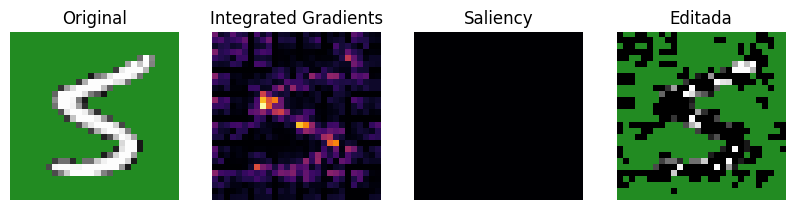

In [225]:
img_path = challenge_dir / '0_label5.png'
y_true = 5

orig_pil = Image.open(img_path).convert('RGB')
x0 = to_tensor(orig_pil).unsqueeze(0).to(device)

print(f"Pred inicial: {get_pred(model, x0)}")

ig_t  = integrated_grad_map(model, x0, y_true)
sal_t = saliency_map(model, x0, y_true)

H, W = x0.shape[2], x0.shape[3]
max_pixels = int(0.4 * H * W)

ks = list(range(10, max_pixels, 5))
res = look_over_k(model, x0, y_true, ig_t, ks, mode="off")

if res:

    x_best, k_best, pred_best, changed = res
    edited_pil = to_pil(x_best[0].cpu())

    print(f"Pred final: {pred_best} | k={k_best}")

    edited_dir = (challenge_dir / 'edited')
    edited_dir.mkdir(parents=True, exist_ok=True)
    out_path = edited_dir / img_path.name
    edited_pil.save(out_path)

    show_xai_results(orig_pil, ig_t, sal_t, edited_pil, "0_label5 → 5 (Two-Point)")
else:
    print("No se encontró edición válida con Integrated Gradients.")


Pred inicial: 1 | Label objetivo: 3
Pred final: 3 | k=155


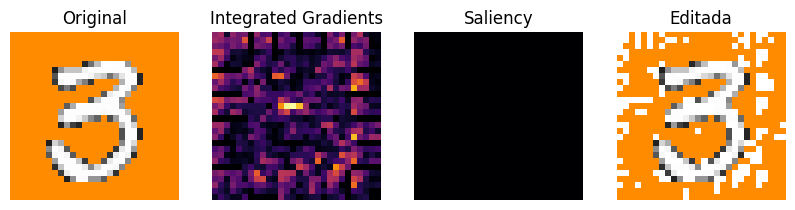

In [226]:
img_path = challenge_dir / '1_label3.png'
y_true = 3

orig_pil = Image.open(img_path).convert('RGB')
x0 = to_tensor(orig_pil).unsqueeze(0).to(device)

print(f"Pred inicial: {get_pred(model, x0)} | Label objetivo: {y_true}")

ig_t  = integrated_grad_map(model, x0, y_true)
sal_t = saliency_map(model, x0, y_true)

H, W = x0.shape[2], x0.shape[3]
max_pixels = int(0.4 * H * W)

ks = list(range(10, max_pixels, 5))
res = look_over_k(model, x0, y_true, ig_t, ks, mode="on")

if res:

    x_best, k_best, pred_best, changed = res
    edited_pil = to_pil(x_best[0].cpu())

    print(f"Pred final: {pred_best} | k={k_best}")

    edited_dir = (challenge_dir / 'edited')
    edited_dir.mkdir(parents=True, exist_ok=True)
    out_path = edited_dir / img_path.name
    edited_pil.save(out_path)

    show_xai_results(orig_pil, ig_t, sal_t, edited_pil, "0_label5 → 5 (Two-Point)")
else:
    print("No se encontró edición válida con Integrated Gradients.")

Pred inicial: 1 | Label objetivo: 3
Pred final: 3 | k=240


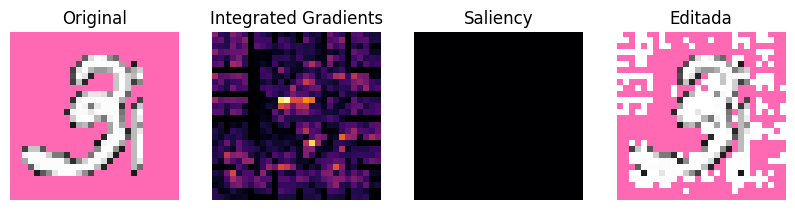

In [227]:
img_path = challenge_dir / '2_label3.png'
y_true = 3

orig_pil = Image.open(img_path).convert('RGB')
x0 = to_tensor(orig_pil).unsqueeze(0).to(device)

print(f"Pred inicial: {get_pred(model, x0)} | Label objetivo: {y_true}")

ig_t  = integrated_grad_map(model, x0, y_true)
sal_t = saliency_map(model, x0, y_true)

H, W = x0.shape[2], x0.shape[3]
max_pixels = int(0.4 * H * W)

ks = list(range(10, max_pixels, 5))
res = look_over_k(model, x0, y_true, ig_t, ks, mode="on")
if res:

    x_best, k_best, pred_best, changed = res
    edited_pil = to_pil(x_best[0].cpu())

    print(f"Pred final: {pred_best} | k={k_best}")

    edited_dir = (challenge_dir / 'edited')
    edited_dir.mkdir(parents=True, exist_ok=True)
    out_path = edited_dir / img_path.name
    edited_pil.save(out_path)

    show_xai_results(orig_pil, ig_t, sal_t, edited_pil, "0_label5 → 5 (Two-Point)")
else:
    print("No se encontró edición válida con Integrated Gradients.")

Pred inicial: 3 | Label objetivo: 7
Pred final: 7 | k=20


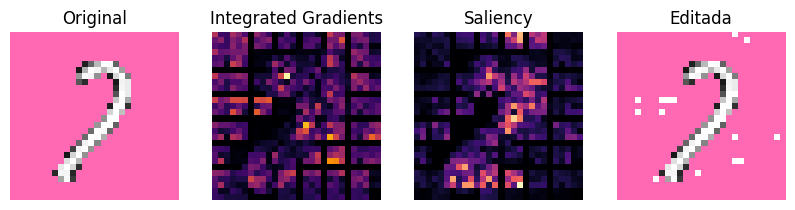

In [228]:
img_path = challenge_dir / '3_label7.png'
y_true = 7

orig_pil = Image.open(img_path).convert('RGB')
x0 = to_tensor(orig_pil).unsqueeze(0).to(device)

print(f"Pred inicial: {get_pred(model, x0)} | Label objetivo: {y_true}")

ig_t  = integrated_grad_map(model, x0, y_true)
sal_t = saliency_map(model, x0, y_true)

combined_map = (0.8 * ig_t + 0.2 * sal_t)
combined_map = combined_map / combined_map.max()

H, W = x0.shape[2], x0.shape[3]
max_pixels = int(0.4 * H * W)

ks = list(range(10, max_pixels, 5))
res = look_over_k(model, x0, y_true, combined_map, ks, mode="on")

if res:

    x_best, k_best, pred_best, changed = res
    edited_pil = to_pil(x_best[0].cpu())

    print(f"Pred final: {pred_best} | k={k_best}")

    edited_dir = (challenge_dir / 'edited')
    edited_dir.mkdir(parents=True, exist_ok=True)
    out_path = edited_dir / img_path.name
    edited_pil.save(out_path)

    show_xai_results(orig_pil, ig_t, sal_t, edited_pil, "0_label5 → 5 (Two-Point)")
else:
    print("No se encontró edición válida con Integrated Gradients.")


Pred inicial: 6 | Label objetivo: 2
Pred final: 2 | k=10


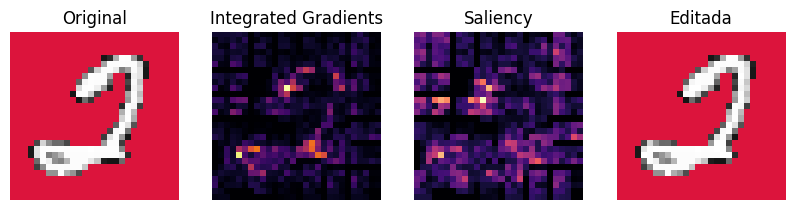

In [229]:
img_path = challenge_dir / '4_label2.png'
y_true = 2

orig_pil = Image.open(img_path).convert('RGB')
x0 = to_tensor(orig_pil).unsqueeze(0).to(device)

print(f"Pred inicial: {get_pred(model, x0)} | Label objetivo: {y_true}")

ig_t  = integrated_grad_map(model, x0, y_true)
sal_t = saliency_map(model, x0, y_true)

combined_map = (0.8 * ig_t + 0.2 * sal_t)
combined_map = combined_map / combined_map.max()

H, W = x0.shape[2], x0.shape[3]
max_pixels = int(0.4 * H * W)

ks = list(range(10, max_pixels, 5))
res = look_over_k(model, x0, y_true, combined_map, ks, mode="on")

if res:

    x_best, k_best, pred_best, changed = res
    edited_pil = to_pil(x_best[0].cpu())

    print(f"Pred final: {pred_best} | k={k_best}")

    edited_dir = (challenge_dir / 'edited')
    edited_dir.mkdir(parents=True, exist_ok=True)
    out_path = edited_dir / img_path.name
    edited_pil.save(out_path)

    show_xai_results(orig_pil, ig_t, sal_t, edited_pil, "0_label5 → 5 (Two-Point)")
else:
    print("No se encontró edición válida con Integrated Gradients.")

---
## Check if you have passed the challenge 

In [230]:
# Check percentage of editing an image
def calculate_edit_percentage(original_img, edited_img):
    original_pixels = original_img.convert("RGB").load()
    edited_pixels = edited_img.convert("RGB").load()
    width, height = original_img.size
    total_pixels = width * height
    changed_pixels = 0

    for x in range(width):
        for y in range(height):
            if original_pixels[x, y] != edited_pixels[x, y]:
                changed_pixels += 1

    return (changed_pixels / total_pixels) * 100

In [231]:
# Create edited directory
edited_dir = challenge_dir / 'edited'

# Load edited images, check that they are predicted correctly and calculate edit percentages
for original_img_file, edited_img_file in zip(challenge_dir.glob('*.png'), edited_dir.glob('*.png')):
    original_img = Image.open(original_img_file)
    edited_img = Image.open(edited_img_file)
    # Convert the edited image to RGB if it's not
    if edited_img.mode != 'RGB':
        edited_img = edited_img.convert('RGB')

    # Check prediction
    img_tensor = to_tensor(edited_img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        pred = output.argmax(dim=1).item()
    
    print(f'Edited {edited_img_file.name}: Pred: {pred}, Label: {original_img_file.stem[-1]}, correct: {pred == int(original_img_file.stem[-1])}')

    # Calculate edit percentage
    edit_percentage = calculate_edit_percentage(original_img, edited_img)
    print(f'Edit Percentage: {edit_percentage:.2f}%')


Edited 0_label5.png: Pred: 5, Label: 5, correct: True
Edit Percentage: 31.25%
Edited 1_label3.png: Pred: 3, Label: 3, correct: True
Edit Percentage: 19.77%
Edited 2_label3.png: Pred: 3, Label: 3, correct: True
Edit Percentage: 30.61%
Edited 3_label7.png: Pred: 7, Label: 7, correct: True
Edit Percentage: 2.42%
Edited 4_label2.png: Pred: 2, Label: 2, correct: True
Edit Percentage: 1.28%
